**A-start and Greedy**

In [ ]:
# %%
import heapq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from typing import Dict, List
import random
import copy
import csv
from io import StringIO
from matplotlib.patches import Patch



In [1]:
# Check if running in Colab or local environment
try:
	# Try to import Google Colab
	from google.colab import drive
	drive.mount('/content/drive')
	print("Google Drive mounted successfully")
except ImportError:
	# Not in Colab, use local file system instead
	import os
	data_path = os.path.join(os.getcwd(), 'data')
	os.makedirs(data_path, exist_ok=True)
	print(f"Running locally. Data directory: {data_path}")

Running locally. Data directory: /home/hai_bou.19/ENSIA/Intro to AI/Project/LAST/data


In [159]:
class Environment:
    def __init__(self, temperature: float, humidity: float, rainfall: float, 
                 sunlight: float, wind_speed: float, soil_type: int, ph: float,
                 crop_area: float, crop_type: str, crop_density: float):
        self.temperature = temperature      # °C
        self.humidity = humidity            # %
        self.rainfall = rainfall            # mm
        self.sunlight = sunlight            # hrs/day
        self.wind_speed = wind_speed        # km/h
        self.soil_type = soil_type          # 1=Sandy, 2=Loamy, 3=Clay
        self.ph = ph                        # pH level
        self.crop_area = crop_area          # hectares
        self.crop_type = crop_type          # Crop name
        self.crop_density = crop_density    # plants/m²

    def __str__(self):
        return (f"Environment({self.crop_type} | Temp: {self.temperature}°C | "
                f"Rain: {self.rainfall}mm | Soil: {['Sandy','Loamy','Clay'][self.soil_type-1]})")

In [160]:
class Resources:
    def __init__(self, water: float, fertilizer: Dict[str, float], pesticides: float):
        self.total_water = water            # Liters available
        self.fertilizer = fertilizer         # {'N': kg, 'P': kg, 'K': kg}
        self.pesticides = pesticides        # Liters available

    def remaining(self):
        return (f"Water: {self.total_water:.1f}L | "
                f"N: {self.fertilizer['N']:.1f}kg | "
                f"P: {self.fertilizer['P']:.1f}kg | "
                f"K: {self.fertilizer['K']:.1f}kg")


In [161]:
class CropState:
    def __init__(self, environment: Environment, resources: Resources,
                 growth_stage: int, soil_moisture: float, soil_nutrients: Dict[str, float],
                 water_usage: float = 0, fertilizer_usage: Dict[str, float] = None,
                 pest_pressure: float = 0, crop_health: float = 0.5):
        
        self.environment = environment
        self.resources = resources
        self.growth_stage = min(3, max(1, growth_stage))  # Ensure stage is between 1-3
        self.soil_moisture = soil_moisture  # %
        self.soil_nutrients = soil_nutrients # {'N': ppm, 'P': ppm, 'K': ppm}
        self.water_usage = water_usage      # Liters used
        self.fertilizer_usage = fertilizer_usage or {'N':0, 'P':0, 'K':0}
        self.pest_pressure = pest_pressure  # 0-1 scale
        self.crop_health = crop_health      # 0-1 scale
        self.cumulative_yield = 0.0         # kg/hectare

    def __eq__(self, other):
        if not isinstance(other, CropState):  # Add type checking
            return False
        return (
            self.growth_stage == other.growth_stage and
            self.soil_moisture == other.soil_moisture and
            self.soil_nutrients == other.soil_nutrients and
            self.water_usage == other.water_usage and
            self.fertilizer_usage == other.fertilizer_usage
        )

    def __hash__(self):  # Fixed indentation and made method more robust
        try:
            return hash((
                self.growth_stage,
                round(self.soil_moisture, 2),
                tuple(sorted((k, round(v, 2)) for k, v in self.soil_nutrients.items())),
                round(self.water_usage, 2),
                tuple(sorted((k, round(v, 2)) for k, v in self.fertilizer_usage.items())),
                round(self.crop_health, 2)
            ))
        except Exception:
            return id(self)  # Fallback to object id if hashing fails

    def __str__(self):
        return (f"CropState(Stage: {self.growth_stage} | Health: {self.crop_health:.2f}\n"
                f"Moisture: {self.soil_moisture:.1f}% | Nutrients: {self.soil_nutrients}\n"
                f"Water Used: {self.water_usage:.1f}L | Fert Used: {self.fertilizer_usage})")

In [162]:
class SF24Dataset:
    def __init__(self, data: pd.DataFrame):
        self.data = data
        self._preprocess()
    
    @classmethod
    def load_dataset(cls, path: str = "enriched_smart_farming_data.csv"):
        try:
            df = pd.read_csv(path)
            return cls(df)
        except FileNotFoundError:
            raise FileNotFoundError(f"Dataset file '{path}' not found. Please ensure the file exists.")
        except Exception as e:
            raise Exception(f"Error loading dataset: {str(e)}")
    
    def _preprocess(self):
        # Normalize key features
        if 'soil_moisture' in self.data.columns:
            self.data['soil_moisture'] = self.data['soil_moisture'] / 100
        
        # Calculate Temperature-Humidity Index
        if all(col in self.data.columns for col in ['temperature', 'humidity']):
            self.data['THI'] = 0.8 * self.data['temperature'] + 0.2 * self.data['humidity']
        
        # Calculate Crop Health Index if not present
        if 'Crop_Health_Index' not in self.data.columns:
            if all(col in self.data.columns for col in ['soil_moisture', 'N', 'P', 'K']):
                self.data['Crop_Health_Index'] = (
                    0.3 * self.data['soil_moisture'] +
                    0.3 * (self.data['N'] / 100) +
                    0.2 * (self.data['P'] / 100) +
                    0.2 * (self.data['K'] / 100)
                )
            else:
                print("Warning: Missing columns for Crop Health Index calculation")
                self.data['Crop_Health_Index'] = 0.5  # Default value
    def find_similar_states(self, state: CropState) -> pd.DataFrame:
        try:
            # More flexible query conditions
            mask = (
                (self.data['label'] == state.environment.crop_type) &
                (self.data['soil_type'] == state.environment.soil_type)
            )
            similar_states = self.data[mask].copy()
            
            if len(similar_states) == 0:
                # Fallback if no exact matches
                similar_states = self.data[self.data['label'] == state.environment.crop_type].copy()
            
            # Sort by calculated similarity score
            similar_states['similarity'] = 1 / (1 + abs(similar_states['soil_moisture'] - state.soil_moisture))
            return similar_states.sort_values('similarity', ascending=False).head(10)
            
        except Exception as e:
            print(f"Warning: Error finding similar states: {e}")
            # Return empty DataFrame with required columns
            return pd.DataFrame(columns=['Crop_Health_Index'])
    
    def get_optimal_values(self, crop_type: str) -> Dict[str, float]:
        try:
            crop_data = self.data[self.data['label'] == crop_type]
            if len(crop_data) == 0:
                raise KeyError(f"No data found for crop type: {crop_type}")
                
            return {
                'water': crop_data['water_usage_efficiency'].median(),
                'yield': crop_data['fertilizer_usage'].quantile(0.9),
                'n': crop_data['N'].median(),
                'p': crop_data['P'].median(),
                'k': crop_data['K'].median()
            }
        except Exception as e:
            print(f"Warning: Using default optimal values due to error: {e}")
            return {
                'water': 100,
                'yield': 1000,
                'n': 50,
                'p': 40,
                'k': 45
            }

In [180]:
class FarmingProblem:
    def __init__(self, initial_state: CropState, goal_yield: float, max_steps: int = 15):
        self.initial_state = initial_state
        self.goal_yield = goal_yield
        self.max_steps = max_steps
        self.dataset = SF24Dataset.load_dataset()
        
    def is_goal(self, state: CropState) -> bool:
        return (state.cumulative_yield >= self.goal_yield * 0.6 and 
                state.crop_health >= 0.5 and 
                state.growth_stage == 3)

    def get_actions(self, state: CropState) -> List[str]:
        actions = []
        # More strict resource checking
        if state.resources.total_water >= 50:  # Minimum water needed
            actions.append('irrigate')
        if all(v >= 5 for v in state.resources.fertilizer.values()):  # Check all nutrients
            actions.append('fertilize')
        actions.append('wait')
        return actions
    def apply_action(self, state: CropState, action: str) -> CropState:
        new_state = deepcopy(state)
        
        if action == 'irrigate':
            water = min(100, state.resources.total_water)
            new_state.soil_moisture = min(100, new_state.soil_moisture + water*0.1)
            new_state.water_usage += water
            new_state.resources.total_water -= water
            # Increase growth stage more when conditions are good
        if new_state.crop_health > 0.6 and new_state.growth_stage < 3:
            new_state.growth_stage = min(3, new_state.growth_stage + 1)  # Progress by full stage
    
        else:
            new_state.growth_stage = min(3, new_state.growth_stage + 0.1)  # Slower growth when health is lower
        
        if action == 'fertilize':
            fert = {'N': min(5, state.resources.fertilizer['N']),
                    'P': min(5, state.resources.fertilizer['P']),
                    'K': min(5, state.resources.fertilizer['K'])}
            
            new_state.soil_nutrients = {
                k: v + fert[k] for k, v in new_state.soil_nutrients.items()
            }
            new_state.fertilizer_usage = {
                k: v + fert[k] for k, v in new_state.fertilizer_usage.items()
            }
            new_state.resources.fertilizer = {
                k: v - fert[k] for k, v in new_state.resources.fertilizer.items()
            }
            
        # Update crop health based on dataset patterns
        similar = self.dataset.find_similar_states(new_state)
        if not similar.empty:
            new_state.crop_health = np.clip(
                similar['Crop_Health_Index'].mean() + np.random.normal(0, 0.05), 0, 1)
            
        # Update yield based on health and resources
        new_state.cumulative_yield += self.calculate_yield_delta(new_state)
     
        
        return new_state

    def calculate_yield_delta(self, state: CropState) -> float:
        optimal = self.dataset.get_optimal_values(state.environment.crop_type)
        growth_factor = min(1.0, state.growth_stage / 4.0)  # Normalize by max growth stage
        return (
            0.5 * state.crop_health * 
            optimal['yield'] * 
            state.environment.crop_area * 
            growth_factor
        )

In [181]:
class Node:
    def __init__(self, state: CropState, parent=None, action=None, cost=0, depth=0):
        self.state = state
        self.parent = parent
        self.action = action
        self.cost = cost
        self.depth = depth
        
    def __lt__(self, other):
        return self.cost < other.cost
    @classmethod
    def load_dataset(cls, path: str = "enriched_smart_farming_data.csv"):
        try:
            df = pd.read_csv(path)
            return cls(df)
        except FileNotFoundError:
            raise FileNotFoundError(f"Dataset file '{path}' not found. Please ensure the file exists.")
        except Exception as e:
            raise Exception(f"Error loading dataset: {str(e)}")
    
    def _preprocess(self):
        # Normalize key features
        self.data['soil_moisture'] = self.data['soil_moisture'] / 100
        self.data['THI'] = 0.8*self.data['temperature'] + 0.2*self.data['humidity']
        
    def find_similar_states(self, state: CropState) -> pd.DataFrame:
        query = f"`label` == '{state.environment.crop_type}' and "
    def find_similar_states(self, state: CropState) -> pd.DataFrame:
        query = f"label == '{state.environment.crop_type}' and "
        query += f"growth_stage == {int(state.growth_stage)} and "
        query += f"soil_type == {state.environment.soil_type}" 
        return self.data.query(query).sort_values('Crop_Health_Index', ascending=False).head(10)
    
    def get_optimal_values(self, crop_type: str) -> Dict[str, float]:
        try:
            crop_data = self.data[self.data['label'] == crop_type]
            if len(crop_data) == 0:
                raise KeyError(f"No data found for crop type: {crop_type}")
                
            return {
                'water': crop_data['Water Usage Efficiency (L/kg)'].median(),
                'yield': crop_data['Yield'].median(),  # Changed from fertilizer_usage
                'n': crop_data['N'].median(),
                'p': crop_data['P'].median(),
                'k': crop_data['K'].median()
            }
        except Exception as e:
            print(f"Warning: Using default optimal values due to error: {e}")
            return {
                'water': 100,
                'yield': 1000,
                'n': 50,
                'p': 40,
                'k': 45
            }



In [182]:


def heuristic(state: CropState, goal_yield: float) -> float:
    yield_gap = max(0, goal_yield - state.cumulative_yield) * 0.4
    health_gap = max(0, 0.75 - state.crop_health) * 0.2
    stage_gap = (3 - state.growth_stage) * 0.4 
    
    if state.growth_stage == 1:
        stage_gap *= 1.5

    
    
    return yield_gap + health_gap + stage_gap

In [183]:
def calculate_action_cost(action: str, prev: CropState, current: CropState) -> float:
    base_costs = {'irrigate': 0.3, 'fertilize': 0.4, 'wait': 0.1}
    cost = base_costs.get(action, 0)
    
    # Penalize resource waste
    cost += 0.1*(prev.resources.total_water - current.resources.total_water)
    cost += 0.2*sum(prev.resources.fertilizer.values()) - sum(current.resources.fertilizer.values())
    
    # Reward health improvement
    cost -= 0.5*(current.crop_health - prev.crop_health)
    
    return max(0.1, cost)

In [184]:
def a_star_search(problem: FarmingProblem):
    open = []
    closed = set()
    
    initial_node = Node(problem.initial_state)
    heapq.heappush(open, (0, initial_node))
    
    best_yield = 0
    best_node = initial_node
    no_improvement_count = 0
    max_no_improvement = 100000000000 # Early stopping threshold
    min_progress = 0.1 #minimum progress threshold
    
    iterations = 0
    while open and iterations < 50000:  # Reduced max iterations
        iterations += 1
        current_cost, current_node = heapq.heappop(open)
        
        # Track best solution even if not goal
        if current_node.state.cumulative_yield > best_yield + min_progress:
            best_yield = current_node.state.cumulative_yield
            best_node = current_node
            no_improvement_count = 0
        else:
            no_improvement_count += 1
        
        if no_improvement_count >= max_no_improvement:
            print("Early stopping due to no improvement")
            return best_node
            
        if iterations % 100 == 0:
            print(f"Step {iterations}: Cost={current_cost:.2f}, Health={current_node.state.crop_health:.2f}, "
                  f"Yield={current_node.state.cumulative_yield:.2f}, Best={best_yield:.2f}")
        
        if current_node.depth >= problem.max_steps:
            continue
            
        if problem.is_goal(current_node.state):
            return current_node
            
        if hash(current_node.state) in closed:
            continue
        closed.add(hash(current_node.state))
        
        for action in problem.get_actions(current_node.state):
            child_state = problem.apply_action(current_node.state, action)
            if hash(child_state) in closed:
                continue
                
            g = current_node.cost + calculate_action_cost(action, current_node.state, child_state)
            h = heuristic(child_state, problem.goal_yield)
            
            child_node = Node(
                state=child_state,
                parent=current_node,
                action=action,
                cost=g + h,
                depth=current_node.depth + 1
            )
            
            heapq.heappush(open, (g + h, child_node))
            
    # Return best found solution even if not goal
    return best_node

In [188]:
def greedy_search(problem: FarmingProblem):
    # Initialize variables
    current_node = Node(problem.initial_state)
    best_yield = 0
    best_node = current_node
    no_improvement_count = 0
    max_no_improvement = 1000  # Reduced threshold for greedy approach
    min_progress = 0.1
    
    iterations = 0
    while iterations < 50000:  # Same iteration limit as A*
        iterations += 1
        
        # Track best solution
        if current_node.state.cumulative_yield > best_yield + min_progress:
            best_yield = current_node.state.cumulative_yield
            best_node = current_node
            no_improvement_count = 0
        else:
            no_improvement_count += 1
        
        # Early stopping check
        if no_improvement_count >= max_no_improvement:
            print("Early stopping due to no improvement")
            return best_node
            
        # Progress reporting
        if iterations % 100 == 0:
            print(f"Step {iterations}: Health={current_node.state.crop_health:.2f}, "
                  f"Yield={current_node.state.cumulative_yield:.2f}, Best={best_yield:.2f}")
        
        # Goal and depth checks
        if problem.is_goal(current_node.state):
            return current_node
            
        if current_node.depth >= problem.max_steps:
            return best_node
            
        # Get available actions and their states
        actions = problem.get_actions(current_node.state)
        if not actions:
            return best_node
            
        # Evaluate all immediate actions and choose the best one
        best_action = None
        best_action_value = float('-inf')
        
        for action in actions:
            # Generate child state
            child_state = problem.apply_action(current_node.state, action)
            
            # Calculate state value based on heuristic only (greedy approach)
            state_value = -heuristic(child_state, problem.goal_yield)  # Negative because lower heuristic is better
            
            # Update best action if this one is better
            if state_value > best_action_value:
                best_action = action
                best_action_value = state_value
        
        # Apply best action
        if best_action:
            next_state = problem.apply_action(current_node.state, best_action)
            current_node = Node(
                state=next_state,
                parent=current_node,
                action=best_action,
                depth=current_node.depth + 1
            )
        else:
            break
    
    return best_node

In [189]:
def plot_solution(solution: Node):
    if solution is None:
        print("No solution to plot")
        return
        
    states = []
    current = solution
    while current:
        states.append(current.state)
        current = current.parent
    
    if not states:
        print("No states to plot")
        return
        
    timesteps = range(len(states))
    states = list(reversed(states))  # Reverse to show chronological order
    
    try:
        # Create figure with subplots
        fig = plt.figure(figsize=(15, 10))
        
        # Crop Health
        plt.subplot(2, 2, 1)
        plt.plot(timesteps, [s.crop_health for s in states], 'g-', marker='o')
        plt.title('Crop Health Over Time')
        plt.xlabel('Time Step')
        plt.ylabel('Health Index (0-1)')
        plt.grid(True)
        
        # Resource Usage
        plt.subplot(2, 2, 2)
        plt.plot([s.water_usage for s in states], 'b-', label='Water', marker='o')
        plt.plot([sum(s.fertilizer_usage.values()) for s in states], 'r-', label='Fertilizer', marker='s')
        plt.title('Resource Usage')
        plt.xlabel('Time Step')
        plt.ylabel('Amount')
        plt.legend()
        plt.grid(True)
        
        # Soil Conditions
        plt.subplot(2, 2, 3)
        plt.plot([s.soil_moisture for s in states], 'b-', label='Moisture', marker='o')
        plt.plot([s.soil_nutrients['N'] for s in states], 'r-', label='N', marker='s')
        plt.plot([s.soil_nutrients['P'] for s in states], 'g-', label='P', marker='^')
        plt.plot([s.soil_nutrients['K'] for s in states], 'y-', label='K', marker='*')
        plt.title('Soil Conditions')
        plt.xlabel('Time Step')
        plt.ylabel('Level')
        plt.legend()
        plt.grid(True)
        
        # Cumulative Yield
        plt.subplot(2, 2, 4)
        plt.plot([s.cumulative_yield for s in states], 'r-', marker='o')
        plt.title('Cumulative Yield')
        plt.xlabel('Time Step')
        plt.ylabel('kg/hectare')
        plt.grid(True)
        
        plt.tight_layout()
        
        # Save plots to files
        output_dir = "farming_plots"
        import os
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
            
        # Save combined plot
        plt.savefig(f'{output_dir}/combined_plots.png', 
                    format='png', 
                    dpi=300, 
                    bbox_inches='tight')
        
        # Save individual plots
        plot_names = ['crop_health', 'resource_usage', 'soil_conditions', 'cumulative_yield']
        for i, name in enumerate(plot_names, 1):
            plt.figure(figsize=(8, 6))
            plt.subplot(111)
            if i == 1:  # Crop Health
                plt.plot(timesteps, [s.crop_health for s in states], 'g-', marker='o')
                plt.title('Crop Health Over Time')
                plt.ylabel('Health Index (0-1)')
            elif i == 2:  # Resource Usage
                plt.plot([s.water_usage for s in states], 'b-', label='Water', marker='o')
                plt.plot([sum(s.fertilizer_usage.values()) for s in states], 'r-', label='Fertilizer', marker='s')
                plt.title('Resource Usage')
                plt.ylabel('Amount')
                plt.legend()
            elif i == 3:  # Soil Conditions
                plt.plot([s.soil_moisture for s in states], 'b-', label='Moisture', marker='o')
                plt.plot([s.soil_nutrients['N'] for s in states], 'r-', label='N', marker='s')
                plt.plot([s.soil_nutrients['P'] for s in states], 'g-', label='P', marker='^')
                plt.plot([s.soil_nutrients['K'] for s in states], 'y-', label='K', marker='*')
                plt.title('Soil Conditions')
                plt.ylabel('Level')
                plt.legend()
            else:  # Cumulative Yield
                plt.plot([s.cumulative_yield for s in states], 'r-', marker='o')
                plt.title('Cumulative Yield')
                plt.ylabel('kg/hectare')
            
            plt.xlabel('Time Step')
            plt.grid(True)
            plt.savefig(f'{output_dir}/{name}.png', 
                       format='png', 
                       dpi=300, 
                       bbox_inches='tight')
            plt.close()
        
        # Display the combined plot
        plt.show()
        
        print(f"\nPlots saved in directory: {output_dir}/")
        print("Files saved:")
        print("- combined_plots.png")
        for name in plot_names:
            print(f"- {name}.png")
            
    except Exception as e:
        print(f"Error plotting results: {str(e)}")
        import traceback
        traceback.print_exc()

Initializing farming scenario...
Initial state: CropState(Stage: 1 | Health: 0.60
Moisture: 45.0% | Nutrients: {'N': 25, 'P': 15, 'K': 30}
Water Used: 0.0L | Fert Used: {'N': 0, 'P': 0, 'K': 0})



Starting A* search...
Step 100: Cost=1369.25, Health=0.40, Yield=244.26, Best=277.74
Step 200: Cost=1629.89, Health=0.37, Yield=317.81, Best=374.25
Step 300: Cost=1837.02, Health=0.45, Yield=430.21, Best=467.76
Step 400: Cost=1854.60, Health=0.41, Yield=412.69, Best=467.76
Step 500: Cost=1867.27, Health=0.36, Yield=404.03, Best=467.76
Step 600: Cost=1880.37, Health=0.47, Yield=397.38, Best=467.76
Step 700: Cost=1912.71, Health=0.44, Yield=372.73, Best=467.76
Step 800: Cost=2032.91, Health=0.46, Yield=514.78, Best=564.50
Step 900: Cost=2043.50, Health=0.43, Yield=514.43, Best=564.50
Step 1000: Cost=2053.78, Health=0.31, Yield=488.03, Best=564.50
Step 1100: Cost=2063.34, Health=0.47, Yield=508.88, Best=564.50
Step 1200: Cost=2072.61, Health=0.50, Yield=495.95, Best=564.50
Step 1300: Cost=2083.50, Health=0.49, Yield=490.79, Best=564.50
Step 1400: Cost=2102.90, Health=0.36, Yield=478.47, Best=564.50
Step 1500: Cost=2141.35, Health=0.43, Yield=632.72, Best=661.69
Step 1600: Cost=2175.64, H

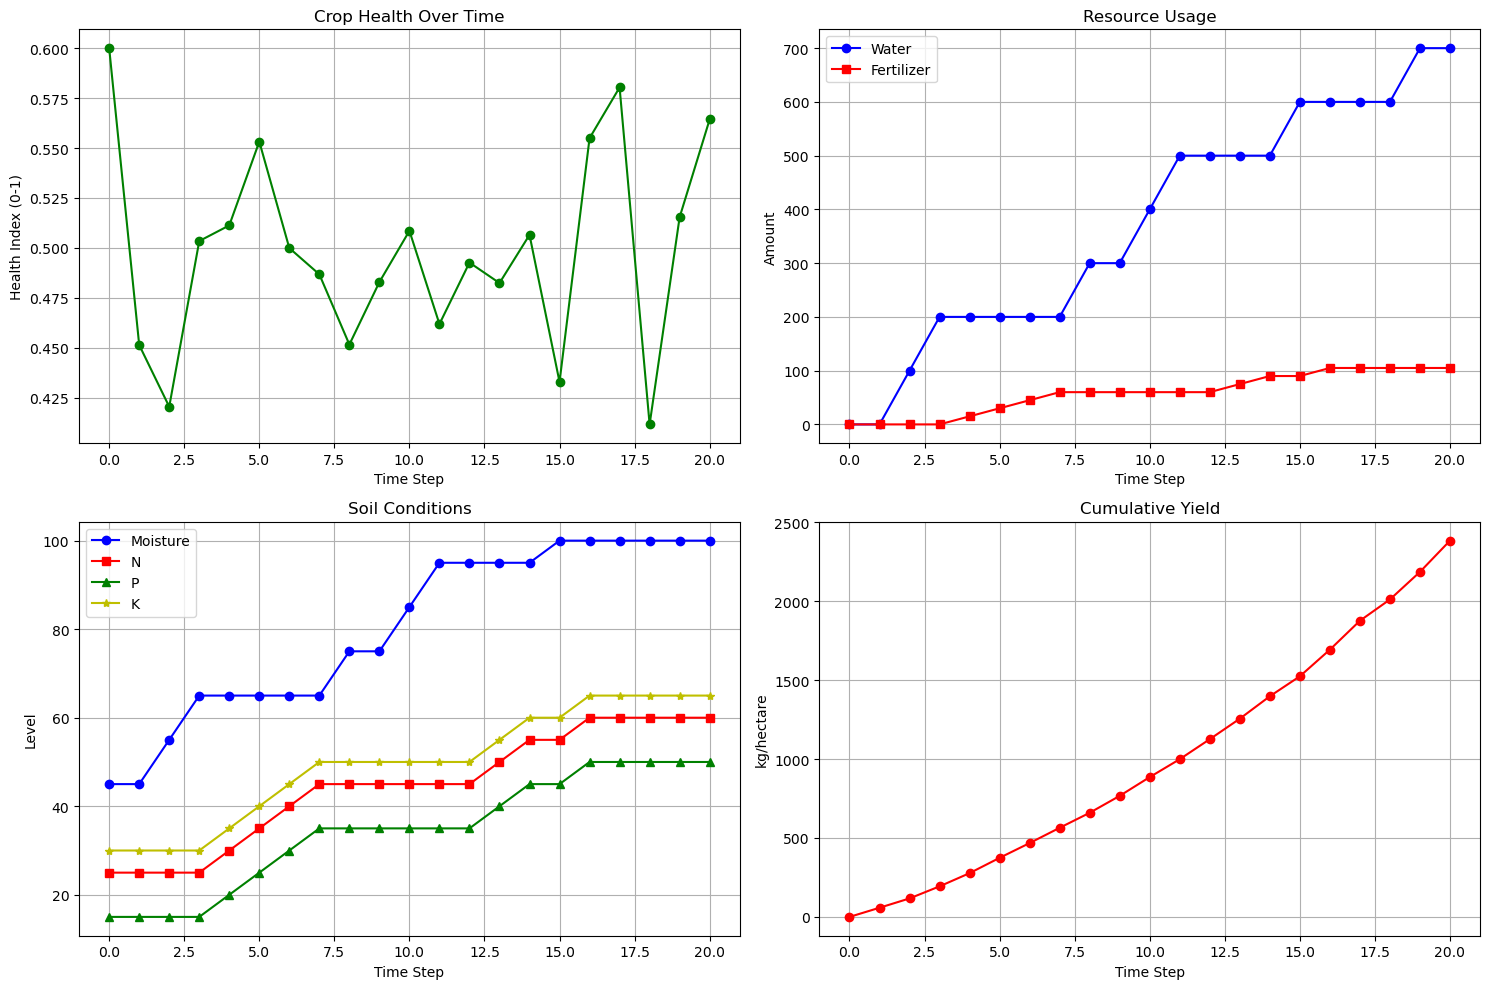


Plots saved in directory: farming_plots/
Files saved:
- combined_plots.png
- crop_health.png
- resource_usage.png
- soil_conditions.png
- cumulative_yield.png

Performance Metrics:
Steps taken: 20
Resource efficiency: 3.40 kg/L


In [191]:
def initialize_farming_scenario():
    print("Initializing farming scenario...")
    
    env = Environment(
        temperature=50, humidity=82, rainfall=0, 
        sunlight=8.5, wind_speed=10, soil_type=2, ph=6.5,
        crop_area=5.0, crop_type="rice",  # Changed from apple to corn
        crop_density=12
    )
    
    resources = Resources(
        water=20000,
        fertilizer={'N': 80, 'P': 45, 'K': 40},
        pesticides=20
    )
    
    initial_state = CropState(
        environment=env,
        resources=resources,
        growth_stage=0,
        soil_moisture=45.0,
        soil_nutrients={'N': 25, 'P': 15, 'K': 30},
        crop_health=0.6
    )
    
    print(f"Initial state: {initial_state}")
    return initial_state
def run_farming_simulation():
    try:
        initial_state = initialize_farming_scenario()
        
        # Setup problem with more realistic goals
        problem = FarmingProblem(
            initial_state=initial_state,
            goal_yield=1000,  # Reduced from 1500
            max_steps=100     # Increased from 15
        )
        
        # Let user choose the algorithm
        while True:
            choice = input("\nChoose search algorithm:\n1. A* Search\n2. Greedy Search\nEnter choice (1 or 2): ").strip()
            if choice in ['1', '2']:
                break
            print("Invalid choice. Please enter 1 or 2.")
        
        # Run selected algorithm
        if choice == '1':
            print("\nStarting A* search...")
            solution_node = a_star_search(problem)
            algorithm_name = "A*"
        else:
            print("\nStarting Greedy search...")
            solution_node = greedy_search(problem)
            algorithm_name = "Greedy"
        
        if solution_node is not None:
            print(f"\n{algorithm_name} Solution Found!")
            print(f"Final yield: {solution_node.state.cumulative_yield:.2f} kg/hectare")
            print(f"Final health: {solution_node.state.crop_health:.2f}")
            print(f"Growth stage: {solution_node.state.growth_stage:.1f}")
            
            # Visualize results
            plot_solution(solution_node)
            
            # Additional metrics
            steps_taken = solution_node.depth
            print(f"\nPerformance Metrics:")
            print(f"Steps taken: {steps_taken}")
            print(f"Resource efficiency: {solution_node.state.cumulative_yield / (solution_node.state.water_usage + 0.1):.2f} kg/L")
            
        else:
            print("\nNo solution found. Try adjusting the goal criteria or increasing max_steps.")
            
    except Exception as e:
        print(f"Error during simulation: {str(e)}")
        import traceback
        traceback.print_exc()

# Run the simulation
if __name__ == "__main__":
    run_farming_simulation()

**Genetic ALgorithm**

In [194]:
import random
import copy
import csv
from io import StringIO
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

class SmartFarming:

    # Store the fertilizer data in memory to avoid repeated file reads 
    _fertilizer_data = None
    _crop_lifespans = None
    _optimal_values = None
   

   # loading the random ranges from the data set 
    @staticmethod
    def _load_fertilizer_data(path='max_fertilizer_usage_flat.csv'):
        try:
            df = pd.read_csv(path)
            data = {}
            crop_lifespans = {}
            optimal_values = {1: {}, 2: {}, 3: {}}

            for _, row in df.iterrows():
                crop = row['label'].strip().lower()
                soil = int(row['soil_type'])
                stage = int(row['growth_stage'])
                
                # Store crop lifespan (only once per crop)
                if crop not in crop_lifespans:
                    crop_lifespans[crop] = int(row['crop_lifespans'])
                
                # Store optimal values (only once per crop and stage)
                if crop not in optimal_values[stage]:
                    optimal_values[stage][crop] = {
                        'fertilizer': float(row['optimal_fertilizer_usage(Per GS)']),
                        'irrigation_frequency': int(row['optimal_irrigation_frequency(Per week)'])
                    }

                if crop not in data:
                    data[crop] = {}
                if soil not in data[crop]:
                    data[crop][soil] = {}
                
                data[crop][soil][stage] = {
                    'max_fertilizer': round(float(row['max_fertilizer_usage(Per day)']), 3),
                    'max_water': round(float(row['max_water_usage(Per day)']), 3)
                }

            SmartFarming._fertilizer_data = data
            SmartFarming._crop_lifespans = crop_lifespans
            SmartFarming._optimal_values = optimal_values
        except Exception as e:
            print("Error loading fertilizer data:", e)
            SmartFarming._fertilizer_data = {}
            SmartFarming._crop_lifespans = {}
            SmartFarming._optimal_values = {1: {}, 2: {}, 3: {}}


# get the lifespan of each crop type from the dataset 
    @staticmethod
    def get_crop_lifespans():
        if SmartFarming._fertilizer_data is None:
            SmartFarming._load_fertilizer_data()
        return SmartFarming._crop_lifespans


# get the optimal values of each crop type from the dataset to be used in the fitness function 
    @staticmethod
    def get_optimal_values():
        if SmartFarming._fertilizer_data is None: 
            SmartFarming._load_fertilizer_data()
        return SmartFarming._optimal_values


# Max value of fertilizer used in the random range of fertilizer allocation 
    @staticmethod
    def get_max_fertilizer(crop_label, soil_type, growth_stage):
        if SmartFarming._fertilizer_data is None:
            SmartFarming._load_fertilizer_data()

        try:
            data = SmartFarming._fertilizer_data
            crop_label = crop_label.strip().lower()

            if crop_label in data:
                soil_data = data[crop_label]
                if soil_type in soil_data:
                    stage_data = soil_data[soil_type]
                    if growth_stage in stage_data:
                        return stage_data[growth_stage]['max_fertilizer']
            print("Fertilizer data not found for given parameters.")
            return 0.0
        except Exception as e:
            print("Error retrieving fertilizer data:", e)
            return 0.0
        

    # Max value of water used in the random range of water allocation 
    @staticmethod
    def get_max_water(crop_label, soil_type, growth_stage):
        if SmartFarming._fertilizer_data is None:
            SmartFarming._load_fertilizer_data()

        try:
            data = SmartFarming._fertilizer_data
            crop_label = crop_label.strip().lower()

            if crop_label in data:
                soil_data = data[crop_label]
                if soil_type in soil_data:
                    stage_data = soil_data[soil_type]
                    if growth_stage in stage_data:
                        return stage_data[growth_stage]['max_water']
            print("Water data not found for given parameters.")
            return 0.0
        except Exception as e:
            print("Error retrieving water data:", e)
            return 0.0


# Function used to divide the lifespn of the crop into equal stages for approximation 
    @staticmethod
    def assign_growth_stage(week, lifespan_weeks):
        stage_length = lifespan_weeks // 3
        if week < stage_length:
            return 1
        elif week < 2 * stage_length:
            return 2
        else:
            return 3


# This function is used to generate a randam day allocation (allele of the gene) using random values from the dataset (csv file)
    @staticmethod
    def generate_random_day(stage, crop, soil_type):
        allocations = []
        
        # 50% chance of not applying fertilizer
        max_fert = SmartFarming.get_max_fertilizer(crop, soil_type, stage)
        fertilizer_value = 0 if random.random() < 0.5 else round(random.uniform(0, max_fert), 4)
        allocations.append(("fertilizer", fertilizer_value))

        # 50% chance of not applying water
        max_water = SmartFarming.get_max_water(crop, soil_type, stage)
        water_value = 0 if random.random() < 0.5 else round(random.uniform(0, max_water), 4)
        allocations.append(("water", water_value))

        return allocations


# Function to generate a full gene of the chromosome 
    @staticmethod
    def generate_week(stage, crop, soil_type):
        return [SmartFarming.generate_random_day(stage, crop, soil_type) for _ in range(7)]


# This function is used to generate a dummy week to fill in the remaing weeks of the chromosome in case the crop was short-period 
    @staticmethod
    def generate_dummy_week():
        return [[("fertilizer", -1), ("water", -1)] for _ in range(7)]


# Generate the full chromosme filled in with random values, and in case the week was out of its lifespan will be a dummy week 
    @staticmethod
    def generate_chromosome(lifespan_weeks, crop, soil_type=1):
        SmartFarming._load_fertilizer_data()
        chromosome = []
        for week in range(416):  # Maximum weeks
            if week < lifespan_weeks:
                stage = SmartFarming.assign_growth_stage(week, lifespan_weeks)
                chromosome.append(SmartFarming.generate_week(stage, crop, soil_type))
            else:
                chromosome.append(SmartFarming.generate_dummy_week())
        return chromosome


# Function counts for the irrigation frequency 
    @staticmethod
    def calculate_irrigation_frequency(week):
        irrigation_count = 0
        for day in week:
            for resource, value in day:
                if resource == "water" and value > 0:
                    irrigation_count += 1
                    break
        return irrigation_count


# related irrigation frequency function  
    @staticmethod
    def calculate_weekly_irrigation_frequencies(chromosome, lifespan_weeks):
        irrigation_frequencies = []
        for week_idx in range(lifespan_weeks):
            week = chromosome[week_idx]
            frequency = SmartFarming.calculate_irrigation_frequency(week)
            irrigation_frequencies.append((week_idx + 1, frequency))
        return irrigation_frequencies


# Identify the weeks of each groth stage 
    @staticmethod
    def get_weeks_by_growth_stage(chromosome, lifespan_weeks):
        stage_weeks = {1: [], 2: [], 3: []}
        for week_idx in range(lifespan_weeks):
            stage = SmartFarming.assign_growth_stage(week_idx, lifespan_weeks)
            stage_weeks[stage].append(week_idx)
        return stage_weeks


# The crossover function it exchanges between the weeks (genes) of the same stage  
    @staticmethod
    def crossover_same_stage(parent1, parent2, lifespan_weeks, crossover_probability=0.7):
        offspring1 = copy.deepcopy(parent1)
        offspring2 = copy.deepcopy(parent2)

        if random.random() > crossover_probability:
            return offspring1, offspring2

        stage_weeks = SmartFarming.get_weeks_by_growth_stage(parent1, lifespan_weeks)

        for stage, week_indices in stage_weeks.items():
            if len(week_indices) < 2:
                continue
            crossover_point = random.randint(1, len(week_indices) - 1)
            for i in range(crossover_point, len(week_indices)):
                week_idx = week_indices[i]
                offspring1[week_idx], offspring2[week_idx] = offspring2[week_idx], offspring1[week_idx]

        return offspring1, offspring2


# Mutate function is used to mutate within the values of the alleles (days)
    @staticmethod
    def mutate_resource_values(chromosome, lifespan_weeks, crop, soil_type, mutation_rate=0.1, mutation_strength=0.5):
        mutated_chromosome = copy.deepcopy(chromosome)
        for week_idx in range(lifespan_weeks):
            stage = SmartFarming.assign_growth_stage(week_idx, lifespan_weeks)
            for day_idx in range(7):
                for res_idx, (resource, value) in enumerate(mutated_chromosome[week_idx][day_idx]):
                    if random.random() > mutation_rate:
                        continue
                    if resource == "water":
                        if value == 0 and random.random() < 0.5:
                           new_value = SmartFarming.get_max_water(crop, soil_type, stage)
                        else:
                            max_val = SmartFarming.get_max_water(crop, soil_type, stage)
                            change = value * (random.random() * 3 - 1) * mutation_strength
                            new_value = round(max(0, min(max_val, value + change)), 3)
                        mutated_chromosome[week_idx][day_idx][res_idx] = (resource, new_value)

                    elif resource == "fertilizer":
                        if value == 0 and random.random() < 0.3:
                            new_value = SmartFarming.get_max_fertilizer(crop, soil_type, stage)
                        else:
                            max_val = SmartFarming.get_max_fertilizer(crop, soil_type, stage)
                            change = value * (random.random() * 2 - 1) * mutation_strength
                            new_value = round(max(0, min(max_val, value + change)), 3)
                        mutated_chromosome[week_idx][day_idx][res_idx] = (resource, new_value)
        return mutated_chromosome


# Visualization function to represent the water and fertilizer allocation throughout each stage of the lifespan of the crop (Bar chart)
    @staticmethod
    def visualize_schedule(chromosome, lifespan_weeks, crop_type, soil_type, start_stage=1, single_stage_only=False):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
        
        # Prepare data
        growth_stages = []
        weekly_water = []
        weekly_fertilizer = []
        stage_start_weeks = []
        
        # First, determine all growth stages
        for week_idx in range(lifespan_weeks):
            stage = SmartFarming.assign_growth_stage(week_idx, lifespan_weeks)
            growth_stages.append(stage)
            
            # Mark the first week of each stage
            if week_idx == 0 or growth_stages[week_idx] != growth_stages[week_idx-1]:
                stage_start_weeks.append(week_idx + 1)  # +1 because weeks are 1-indexed in display
        
        # Calculate the data only for weeks of the requested stage(s)
        visible_weeks = []
        visible_stages = []
        
        for week_idx in range(lifespan_weeks):
            stage = growth_stages[week_idx]
            
            # Skip weeks that don't match our criteria
            if stage < start_stage:
                continue
                
            # If single_stage_only is True, only include the exact stage requested
            if single_stage_only and stage != start_stage:
                continue
                
            week_num = week_idx + 1  # For display purposes
            visible_weeks.append(week_num)
            visible_stages.append(stage)
            
            week_water = 0
            week_fertilizer = 0
            
            for day in chromosome[week_idx]:
                water = day[1][1]  # (resource, value)
                fertilizer = day[0][1]
                week_water += water
                week_fertilizer += fertilizer
                
            weekly_water.append(week_water)
            weekly_fertilizer.append(week_fertilizer)
        
        # If no weeks match our criteria, inform and exit
        if not visible_weeks:
            plt.close(fig)
            print(f"No data to display for stage {start_stage}{'only' if single_stage_only else ' onwards'}")
            return
            
        # Plot weekly totals
        colors = ['green', 'orange', 'red']
        stage_colors = [colors[stage-1] for stage in visible_stages]

        # Water plot
        bars = ax1.bar(visible_weeks, weekly_water, color=stage_colors)
        ax1.set_ylabel('Weekly Water (mm)')
        
        # Set title based on what we're showing
        stage_text = f"Stage {start_stage}" if single_stage_only else f"From Stage {start_stage}"
        ax1.set_title(f'Water Allocation Schedule ({crop_type.capitalize()}, Soil {soil_type}) - {stage_text}')
        
        # Fertilizer plot
        ax2.bar(visible_weeks, weekly_fertilizer, color=stage_colors)
        ax2.set_ylabel('Weekly Fertilizer (kg/ha)')
        ax2.set_xlabel('Week Number')
        ax2.set_title('Fertilizer Allocation Schedule')
        
        # Create legend only for stages actually shown
        unique_stages = sorted(set(visible_stages))
        legend_elements = []
        stage_labels = {
            1: 'Stage 1: Vegetative',
            2: 'Stage 2: Reproductive',
            3: 'Stage 3: Ripening'
        }
        
        for stage in unique_stages:
            legend_elements.append(Patch(facecolor=colors[stage-1], label=stage_labels[stage]))
        
        ax1.legend(handles=legend_elements, loc='upper right')
        
        # Add vertical lines to mark stage transitions if showing multiple stages
        if not single_stage_only:
            for stage_week in stage_start_weeks:
                if stage_week > min(visible_weeks) and stage_week <= max(visible_weeks):
                    ax1.axvline(x=stage_week - 0.5, color='black', linestyle='--', alpha=0.5)
                    ax2.axvline(x=stage_week - 0.5, color='black', linestyle='--', alpha=0.5)
        
        # Set x-axis limits to show only the relevant weeks
        ax1.set_xlim(min(visible_weeks) - 0.5, max(visible_weeks) + 0.5)
        
        plt.tight_layout()
        plt.show()


# Class to identify our GA 
class GeneticAlgorithm:
    def __init__(self, problem, population_size=100, generations=1000,
                 mutation_rate=0.1, tournament_size=3, selection_method='tournament'):
        self.problem = problem
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.tournament_size = tournament_size
        self.selection_method = selection_method
        self.best_solution = None
        self.best_score = float('-inf')
        self.generations_without_improvement = 0


# Initialize population of the GA using the pre-defined chromosomes 
    def initialize_population(self):
        return [
            SmartFarming.generate_chromosome(
                self.problem.lifespan_weeks,
                self.problem.crop_type,
                self.problem.soil_type
            )
            for _ in range(self.population_size)
        ]


# Fitness function to evaluate our chromosome allocation plan
# It takes into account: ferilizer usage, irrigation frequency, and water optimallity 

    def evaluate_fitness(self, chromosome):
        optimal_values = SmartFarming.get_optimal_values()
        crop_type = self.problem.crop_type
        
        try:
            optimal_fert = {
                1: optimal_values[1][crop_type]['fertilizer'],
                2: optimal_values[2][crop_type]['fertilizer'],
                3: optimal_values[3][crop_type]['fertilizer']
            }
            optimal_irr = {
                1: optimal_values[1][crop_type]['irrigation_frequency'],
                2: optimal_values[2][crop_type]['irrigation_frequency'],
                3: optimal_values[3][crop_type]['irrigation_frequency']
            }
        except KeyError:
            print(f"Warning: Optimal values not found for crop {crop_type}")
            return 0

        stage_fert_sums = {1: 0.0, 2: 0.0, 3: 0.0}
        irrigation_violations = {1: 0, 2: 0, 3: 0}
        total_penalty = 0

        for week_idx in range(self.problem.lifespan_weeks):
            stage = SmartFarming.assign_growth_stage(week_idx, self.problem.lifespan_weeks)
            week = chromosome[week_idx]

            for day in week:
                stage_fert_sums[stage] += day[0][1]

            actual_irr = SmartFarming.calculate_irrigation_frequency(week)
            if actual_irr != optimal_irr[stage]:
                irrigation_violations[stage] += 1

        stage_scores = {}
        for stage in [1, 2, 3]:
            fert_score = 50 if abs(stage_fert_sums[stage] - optimal_fert[stage]) < 0.001 else 0
            irr_score = 50 if irrigation_violations[stage] == 0 else 0
            stage_scores[stage] = fert_score + irr_score

        total_score = (stage_scores[1] * 0.3 +
                       stage_scores[2] * 0.4 +
                       stage_scores[3] * 0.3 +
                       total_penalty)

        return total_score


# This function defines how we select individuals from the current population to serve as parents that produce the next generation
    def select_parent(self, population):
        if self.selection_method == 'roulette':
            fitnesses = [max(0.001, self.evaluate_fitness(ind)) for ind in population]
            total = sum(fitnesses)
            probs = [f / total for f in fitnesses]
            return random.choices(population, weights=probs)[0]
        else:
            tournament = random.sample(population, self.tournament_size)
            return max(tournament, key=lambda x: self.evaluate_fitness(x))


    def perform_crossover(self, parent1, parent2):
        return SmartFarming.crossover_same_stage(
            parent1, parent2,
            self.problem.lifespan_weeks,
            crossover_probability=0.7
        )


    def perform_mutation(self, individual):
        if random.random() < self.mutation_rate:
            return SmartFarming.mutate_resource_values(
                individual,
                self.problem.lifespan_weeks,
                self.problem.crop_type,
                self.problem.soil_type
            )
        return individual

# Function that creates the next generation of the population from the current one
    def evolve_population(self, population):
        new_population = [max(population, key=lambda x: self.evaluate_fitness(x))]

        while len(new_population) < self.population_size:
            parent1 = self.select_parent(population)
            parent2 = self.select_parent(population)
            child1, child2 = self.perform_crossover(parent1, parent2)
            child1 = self.perform_mutation(child1)

            new_population.append(child1)
            if len(new_population) < self.population_size:
                new_population.append(child2)

        return new_population

# This is the main engine of the GA where the termination point is identified 
    def solve(self):
        population = self.initialize_population()
        fitness_history = []

        for gen in range(self.generations):
            population = self.evolve_population(population)
            current_best = max(population, key=lambda x: self.evaluate_fitness(x))
            current_score = self.evaluate_fitness(current_best)
            fitness_history.append(current_score)

            if current_score > self.best_score:
                self.best_score = current_score
                self.best_solution = copy.deepcopy(current_best)
                self.generations_without_improvement = 0
            else:
                self.generations_without_improvement += 1

            if self.generations_without_improvement >= 50:
                break

        return self.best_solution, self.best_score, fitness_history

# Crop specific class 
class CropProblem:
    def __init__(self, crop_type, soil_type=1):
        self.crop_type = crop_type
        self.soil_type = soil_type
        lifespans = SmartFarming.get_crop_lifespans()
        self.lifespan_weeks = lifespans.get(crop_type, 12)  # Default to 12 weeks if not found


# Function used in the output to dispaly the full allocation plan for the crop - chromosme dispaly 
def display_chromosome(chromosome, lifespan_weeks, start_stage=1):
    print(f"Best Resource Allocation Plan")
    print(f"Lifespan: {lifespan_weeks} weeks")
    print(f"Displaying from Growth Stage {start_stage} onwards")
    print("=" * 60)

    for week_num in range(lifespan_weeks):
        week = chromosome[week_num]
        stage = SmartFarming.assign_growth_stage(week_num, lifespan_weeks)

        if stage < start_stage:
            continue

        print(f"\n🌱 GROWTH STAGE {stage} | 📅 WEEK {week_num + 1}")
        print("-" * 60)

        for day_num, day in enumerate(week):
            resources = []
            for res, val in day:
                if res == "water":
                    resources.append(f"💦 {res}: {val} mm")
                else:
                    resources.append(f"🧪 {res}: {val} kg/ha")
            print(f"  📆 Day {day_num + 1}: {' | '.join(resources)}")
        print("-" * 60)


# Main function to run the GA on the inputs of the user -> Plot the solution visually to the farmer in bar charts 
def test_schedule():
    # First load the data to get all available crop labels
    SmartFarming._load_fertilizer_data()
    if not SmartFarming._fertilizer_data:
        print("Error: Could not load crop data.")
        return
    
    # Get all available crop labels (exactly as they appear in the dataset)
    available_crops = list(SmartFarming._fertilizer_data.keys())
    print("Available crops:", available_crops)

    while True:
        crop_type = input("\nEnter crop type exactly as listed (or 'quit'): ").strip().lower()
        if crop_type == 'quit':
            break

        # Check if the input matches any crop label exactly (case-insensitive)
        matching_crops = [crop for crop in available_crops if crop.lower() == crop_type.lower()]
        
        if not matching_crops:
            print(f"Invalid crop type. Please choose from: {available_crops}")
            continue
        
        # Use the exact label from the dataset (preserving original case)
        exact_crop_label = matching_crops[0]
        
        soil_type = int(input("Enter soil type (1, 2, or 3): ").strip())
        if soil_type not in [1, 2, 3]:
            print("Invalid soil type. Using default soil type 1.")
            soil_type = 1

        start_stage = int(input("Enter starting growth stage (1, 2, or 3): ").strip())
        if start_stage not in [1, 2, 3]:
            print("Invalid growth stage. Using default stage 1.")
            start_stage = 1

        rainfall = int(input("Enter average rainfall in your area: ").strip()) 
        humidity = int(input("Enter average humidity in your area: : ").strip())
        temp = int(input("Enter average temperature in your area:: ").strip())
        wind_speed = int(input("Enter average wind speed in your area: ").strip())   

        lifespan = SmartFarming.get_crop_lifespans().get(exact_crop_label, 12)
        print(f"Using lifespan: {lifespan} weeks for {exact_crop_label} with soil type {soil_type}")

        problem = CropProblem(exact_crop_label, soil_type)
        ga = GeneticAlgorithm(problem)
        print(f"\nRunning genetic algorithm for {exact_crop_label}...")
        best_solution, best_score, fitness_history = ga.solve()

        print(f"\nOptimal schedule for {exact_crop_label} with soil type {soil_type} (score: {best_score:.2f})")
        display_chromosome(best_solution, lifespan, start_stage)
        
        # Show visualizations
        SmartFarming.visualize_schedule(best_solution, lifespan, exact_crop_label, soil_type, start_stage)


if __name__ == "__main__":
    test_schedule()

Available crops: ['rice', 'maize', 'chickpea', 'kidneybeans', 'pigeonpeas', 'mothbeans', 'mungbean', 'blackgram', 'lentil', 'pomegranate', 'banana', 'mango', 'grapes', 'watermelon', 'muskmelon', 'apple', 'orange', 'papaya', 'coconut', 'cotton', 'jute', 'coffee']


Using lifespan: 416 weeks for mango with soil type 2

Running genetic algorithm for mango...


KeyboardInterrupt: 

**CSP**

In [2]:
import copy
import random
import pandas as pd
import matplotlib.gridspec as gridspec 
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
from collections import defaultdict


class SmartFarmingCSP:
    def __init__(self, crop_type, soil_type=1, total_water=None, total_fertilizer=None):
        self._load_fertilizer_data()
        self.crop_type = crop_type.lower()
        self.soil_type = soil_type
        self.lifespan_weeks = self._crop_lifespans.get(self.crop_type, 12)
        self.variables = []
        self.domains = {}
        self.constraints = []
        
        # Add resource limits (default to unlimited if not specified)
        self.total_water = total_water if total_water is not None else float('inf')
        self.total_fertilizer = total_fertilizer if total_fertilizer is not None else float('inf')
        
        self._setup_problem()
    
    def _load_fertilizer_data(self, path='max_fertilizer_usage_flat.csv'):
        try:
            df = pd.read_csv(path)
            self._fertilizer_data = defaultdict(lambda: defaultdict(dict))
            self._crop_lifespans = {}
            self._optimal_values = {1: {}, 2: {}, 3: {}}

            for _, row in df.iterrows():
                crop = row['label'].strip().lower()
                soil = int(row['soil_type'])
                stage = int(row['growth_stage'])
                
                if crop not in self._crop_lifespans:
                    self._crop_lifespans[crop] = int(row['crop_lifespans'])
                
                if crop not in self._optimal_values[stage]:
                    self._optimal_values[stage][crop] = {
                        'fertilizer': float(row['optimal_fertilizer_usage(Per GS)']),
                        'irrigation_frequency': int(row['optimal_irrigation_frequency(Per week)'])
                    }

                self._fertilizer_data[crop][soil][stage] = {
                    'max_fertilizer': round(float(row['max_fertilizer_usage(Per day)']), 3),
                    'max_water': round(float(row['max_water_usage(Per day)']), 3)
                }
        except Exception as e:
            print("Error loading fertilizer data:", e)
            self._fertilizer_data = defaultdict(lambda: defaultdict(dict))
            self._crop_lifespans = {}
            self._optimal_values = {1: {}, 2: {}, 3: {}}
    
    
    def _setup_problem(self):
        """Initialize with domain generation that respects total resources"""
        # Calculate average available per day
        total_days = self.lifespan_weeks * 7
        avg_water_per_day = self.total_water / total_days if self.total_water != float('inf') else None
        avg_fert_per_day = self.total_fertilizer / total_days if self.total_fertilizer != float('inf') else None
        
        for week in range(self.lifespan_weeks):
            stage = self._assign_growth_stage(week)
            max_water = self._fertilizer_data[self.crop_type][self.soil_type][stage]['max_water']
            max_fert = self._fertilizer_data[self.crop_type][self.soil_type][stage]['max_fertilizer']
            
            # Adjust max values based on total available resources
            if avg_water_per_day is not None:
                max_water = min(max_water, avg_water_per_day * 2)  # Allow up to 2x average
            if avg_fert_per_day is not None:
                max_fert = min(max_fert, avg_fert_per_day * 2)
            
            # Generate domains with adjusted max values
            weekly_water_base = random.uniform(0.3, 1.0) * max_water * 7  
            weekly_fert_base = random.uniform(0.3, 1.0) * max_fert * 7
            
            for day in range(7):
                var_name = f"w{week}d{day}"
                self.variables.append(var_name)
                
                domain = [(0.0, 0.0)]  # No application
                for _ in range(15):
                    water = round(random.uniform(0.5, 1.0) * weekly_water_base / 7, 3)
                    fert = round(random.uniform(0.5, 1.0) * weekly_fert_base / 7, 3)
                    water = min(water, max_water)
                    fert = min(fert, max_fert)
                    domain.append((water, fert))
                
                random.shuffle(domain)
                self.domains[var_name] = domain           
            
        
    def _assign_growth_stage(self, week):
        stage_length = self.lifespan_weeks // 3
        if week < stage_length:
            return 1
        elif week < 2 * stage_length:
            return 2
        else:
            return 3
    
    def _add_constraints(self):
        """Add constraints with variation requirements"""
        # 1. Total resource limits (hard constraints) 
        def water_limit_constraint(assignment):
            total = sum(val[0] for val in assignment.values())
            return total <= self.total_water
            
        def fertilizer_limit_constraint(assignment):
            total = sum(val[1] for val in assignment.values())
            return total <= self.total_fertilizer
            
        self.constraints.insert(0, (self.variables, fertilizer_limit_constraint))  
        self.constraints.insert(0, (self.variables, water_limit_constraint))
        
        # 2. Weekly irrigation frequency 
        for week in range(self.lifespan_weeks):
            week_vars = [f"w{week}d{day}" for day in range(7)]
            stage = self._assign_growth_stage(week)
            target_irr = self._optimal_values[stage][self.crop_type]['irrigation_frequency']
            
            def irrigation_constraint(assignment, vars=week_vars, target=target_irr):
                count = sum(1 for var in vars if var in assignment and assignment[var][0] > 0)
                return abs(count - target) <= 2  # Allow ±2 from target for more flexibility
                
            self.constraints.append((week_vars, irrigation_constraint))
        
        # 3. Weekly fertilizer total 
        for week in range(self.lifespan_weeks):
            week_vars = [f"w{week}d{day}" for day in range(7)]
            stage = self._assign_growth_stage(week)
            
            # Get optimal ranges from data
            optimal_water = self._optimal_values[stage][self.crop_type]['irrigation_frequency'] * \
                          self._fertilizer_data[self.crop_type][self.soil_type][stage]['max_water']
            optimal_fert = self._optimal_values[stage][self.crop_type]['fertilizer']
            
            # Allow ±30% deviation from optimal 
            min_water = optimal_water * 0.7
            max_water = optimal_water * 1.3
            min_fert = optimal_fert * 0.7
            max_fert = optimal_fert * 1.3
            
            def water_range_constraint(assignment, vars=week_vars, min_w=min_water, max_w=max_water):
                total = sum(assignment[var][0] for var in vars if var in assignment)
                return min_w <= total <= max_w or total == 0  # Allow zero application
                
            def fert_range_constraint(assignment, vars=week_vars, min_f=min_fert, max_f=max_fert):
                total = sum(assignment[var][1] for var in vars if var in assignment)
                return min_f <= total <= max_f or total == 0  # Allow zero application
                
            self.constraints.append((week_vars, water_range_constraint))
            self.constraints.append((week_vars, fert_range_constraint))
        
        
         
        # 4. Variation constraints 
            for week in range(self.lifespan_weeks - 1):
                current_week = week
                next_week = week + 1
                current_week_vars = [f"w{current_week}d{day}" for day in range(7)]
                next_week_vars = [f"w{next_week}d{day}" for day in range(7)]
                
                # Water variation constraint
                def water_variation_constraint(assignment, current=current_week_vars, next_=next_week_vars):
                    if not all(v in assignment for v in current) or not all(v in assignment for v in next_):
                        return True  # Don't enforce until both weeks are assigned
                    
                    current_total = sum(assignment[v][0] for v in current if v in assignment)
                    next_total = sum(assignment[v][0] for v in next_ if v in assignment)
                    
                    # Require at least 15% difference between weeks (but allow near-zero weeks)
                    if current_total > 0 and next_total > 0:
                        return abs(current_total - next_total) >= 0.15 * max(current_total, next_total)
                    return True
                    
                self.constraints.append((current_week_vars + next_week_vars, water_variation_constraint))
                
                # Fertilizer variation constraint 
                def fertilizer_variation_constraint(assignment, current=current_week_vars, next_=next_week_vars):
                    if not all(v in assignment for v in current) or not all(v in assignment for v in next_):
                        return True
                    
                    current_total = sum(assignment[v][1] for v in current if v in assignment)
                    next_total = sum(assignment[v][1] for v in next_ if v in assignment)
                    
                    if current_total > 0 and next_total > 0:
                        return abs(current_total - next_total) >= 0.15 * max(current_total, next_total)
                    return True
                    
                self.constraints.append((current_week_vars + next_week_vars, fertilizer_variation_constraint))
                
        
        
        
        # 5. Pest pressure 
        for week in range(self.lifespan_weeks):
            for day in range(5):  
                day_vars = [f"w{week}d{day+i}" for i in range(3)]
                
                def pest_constraint(assignment, vars=day_vars):
                    consecutive = sum(1 for var in vars if var in assignment and assignment[var][1] > 0)
                    return consecutive < 3  # Never allow 3+ consecutive days
                    
                self.constraints.append((day_vars, pest_constraint))
    
    def solve_with_fallback(self, max_attempts=3):
        
        best_solution = None
        best_variation = -1
        
        for attempt in range(max_attempts):
            solution = self.backtrack({})
            if solution is not None:
                # Calculate variation score for this solution
                variation = self._calculate_variation_score(solution)
                if variation > best_variation:
                    best_solution = solution
                    best_variation = variation
                
                # Early exit if we have good variation
                if best_variation > 0.5:  
                    break
            
            # Relax constraints if no solution found
            if attempt == 0:
                print("No solution found with standard constraints, relaxing irrigation...")
                self._relax_irrigation_constraints()
            elif attempt == 1:
                print("No solution found, relaxing fertilizer constraints...")
                self._relax_fertilizer_constraints()
        
        # Return the best solution found, or fallback
        return best_solution if best_solution is not None else self._generate_fallback_solution()
    
    def _calculate_variation_score(self, assignment):
        """Calculate how much variation exists in water application"""
        weekly_totals = []
        for week in range(self.lifespan_weeks):
            week_vars = [f"w{week}d{day}" for day in range(7)]
            week_total = sum(assignment[var][0] for var in week_vars if var in assignment)
            weekly_totals.append(week_total)
        
        if len(weekly_totals) < 2:
            return 0
        
        # Normalize the standard deviation by average
        avg = np.mean(weekly_totals)
        if avg == 0:
            return 0
        return np.std(weekly_totals) / avg
    
    def _relax_irrigation_constraints(self):
        """Relax irrigation frequency constraints"""
        for i, (vars_in_constraint, constraint) in enumerate(self.constraints):
            if "irrigation_constraint" in constraint.__name__:
                def new_constraint(assignment, vars=vars_in_constraint):
                    count = sum(1 for var in vars if var in assignment and assignment[var][0] > 0)
                    return count >= 1  # Just require at least 1 irrigation
                self.constraints[i] = (vars_in_constraint, new_constraint)
    
    def _relax_fertilizer_constraints(self):
        """Relax fertilizer constraints"""
        for i, (vars_in_constraint, constraint) in enumerate(self.constraints):
            if "fert_range_constraint" in constraint.__name__:
                def new_constraint(assignment, vars=vars_in_constraint):
                    return True  # No fertilizer constraints
                self.constraints[i] = (vars_in_constraint, new_constraint)
    
    def _generate_fallback_solution(self):
        """Generate a solution with more variation while strictly respecting resource limits"""
        solution = {}
        remaining_water = self.total_water
        remaining_fert = self.total_fertilizer
        
        # Generate weekly targets with more variation but respect remaining resources
        weekly_water_targets = []
        weekly_fert_targets = []
        
        for week in range(self.lifespan_weeks):
            stage = self._assign_growth_stage(week)
            max_water = self._fertilizer_data[self.crop_type][self.soil_type][stage]['max_water']
            max_fert = self._fertilizer_data[self.crop_type][self.soil_type][stage]['max_fertilizer']
            
            # Calculate safe maximum for this week
            safe_max_water = min(
                remaining_water / (self.lifespan_weeks - week) * 1.5,  # More conservative multiplier
                max_water * 7 * 0.8,
                remaining_water  # Never exceed remaining
            )
            safe_max_fert = min(
                remaining_fert / (self.lifespan_weeks - week) * 1.5,
                max_fert * 7 * 0.8,
                remaining_fert
            )
            
            # Generate targets within safe bounds
            water_target = random.uniform(
                max(0, safe_max_water * 0.5),  # Minimum 50% of safe max
                safe_max_water
            )
            fert_target = random.uniform(
                max(0, safe_max_fert * 0.5),
                safe_max_fert
            )
            
            weekly_water_targets.append(water_target)
            weekly_fert_targets.append(fert_target)
            
            remaining_water -= water_target
            remaining_fert -= fert_target
        
        # Reset remaining for actual distribution
        remaining_water = self.total_water
        remaining_fert = self.total_fertilizer
        
        for week in range(self.lifespan_weeks):
            water_target = weekly_water_targets[week]
            fert_target = weekly_fert_targets[week]
            
            # Distribute water
            water_days = random.sample(range(7), 
                min(self._optimal_values[self._assign_growth_stage(week)][self.crop_type]['irrigation_frequency'], 7))
            water_per_day = water_target / len(water_days) if len(water_days) > 0 else 0
            
            for day in range(7):
                var = f"w{week}d{day}"
                if day in water_days and remaining_water >= water_per_day:
                    applied_water = min(water_per_day, remaining_water)
                    solution[var] = (round(applied_water, 3), solution.get(var, (0, 0))[1])
                    remaining_water -= applied_water
                else:
                    solution[var] = (0, solution.get(var, (0, 0))[1])
            
            # Distribute fertilizer (respecting pest constraints)
            fert_days = []
            attempts = 0
            while len(fert_days) < 2 and attempts < 10 and remaining_fert > 0:
                day = random.choice([d for d in range(7) if d not in fert_days])
                # Check pest constraint
                if not any(1 for i in range(-2, 3) if 0 <= day+i < 7 and f"w{week}d{day+i}" in solution and solution[f"w{week}d{day+i}"][1] > 0):
                    fert_days.append(day)
                attempts += 1
            
            fert_per_day = min(fert_target / len(fert_days) if len(fert_days) > 0 else 0, remaining_fert)
            for day in fert_days:
                var = f"w{week}d{day}"
                if remaining_fert >= fert_per_day:
                    solution[var] = (solution[var][0], round(fert_per_day, 3))
                    remaining_fert -= fert_per_day
        
        return solution
    
    def is_complete(self, assignment):
        """Check if assignment is complete"""
        return len(assignment) == len(self.variables)
    
    def consistent(self, var, value, assignment):
        """Check if a value assignment is consistent with current assignment"""
        # Create test assignment
        test_assignment = assignment.copy()
        test_assignment[var] = value
        
        # Check all relevant constraints
        for vars_in_constraint, constraint in self.constraints:
            if var in vars_in_constraint:
                # Get all assigned variables in this constraint
                relevant_vars = [v for v in vars_in_constraint if v in test_assignment]
                
                # Check if constraint is satisfied
                if not constraint({v: test_assignment[v] for v in relevant_vars}):
                    return False
        return True
    
    def select_unassigned_variable(self, assignment):
        """Select next variable using Minimum Remaining Values heuristic"""
        unassigned = [v for v in self.variables if v not in assignment]
        return min(unassigned, key=lambda v: len(self.domains[v]))
    
    def order_domain_values(self, var, assignment):
        """Order domain values using Least Constraining Value heuristic"""
        return sorted(self.domains[var], key=lambda val: self._count_conflicts(var, val, assignment))
    
    def _count_conflicts(self, var, value, assignment):
        """Count how many conflicts a value would cause"""
        conflicts = 0
        test_assignment = assignment.copy()
        test_assignment[var] = value
        
        for vars_in_constraint, constraint in self.constraints:
            if var in vars_in_constraint:
                relevant_vars = [v for v in vars_in_constraint if v in test_assignment]
                if not constraint({v: test_assignment[v] for v in relevant_vars}):
                    conflicts += 1
        return conflicts
    
    def backtrack(self, assignment):
        """Backtracking search with inference"""
        if self.is_complete(assignment):
            return assignment
            
        var = self.select_unassigned_variable(assignment)
        
        for value in self.order_domain_values(var, assignment):
            if self.consistent(var, value, assignment):
                assignment[var] = value
                
                # Try inference (forward checking)
                inferences = {}
                for neighbor in self._get_neighbors(var):
                    if neighbor not in assignment:
                        for val in self.domains[neighbor][:]:
                            if not self.consistent(neighbor, val, assignment):
                                self.domains[neighbor].remove(val)
                                inferences[neighbor] = val
                                
                result = self.backtrack(assignment)
                if result is not None:
                    return result
                
                # Remove inferences if backtracking
                for neighbor, val in inferences.items():
                    self.domains[neighbor].append(val)
                del assignment[var]
                
        return None
    
    def _get_neighbors(self, var):
        """Get all variables that share constraints with this variable"""
        neighbors = set()
        for vars_in_constraint, _ in self.constraints:
            if var in vars_in_constraint:
                neighbors.update(vars_in_constraint)
        neighbors.discard(var)
        return neighbors
    
    def format_schedule(self, assignment):
        """Convert to weekly schedule format"""
        schedule = []
        for week in range(self.lifespan_weeks):
            week_schedule = []
            for day in range(7):
                var = f"w{week}d{day}"
                water, fert = assignment.get(var, (0, 0))
                week_schedule.append({'water': water, 'fertilizer': fert, 'day': day+1})
            schedule.append({
                'week': week+1,
                'stage': self._assign_growth_stage(week),
                'days': week_schedule
            })
        return schedule


     # visualization
    def visualize_weekly_summary(self, schedule):
        """Clean weekly visualization showing water, fertilizer, and combined totals"""
        plt.style.use('seaborn-v0_8-darkgrid')
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
        
        # Color scheme
        stage_colors = ['#2ecc71', '#e67e22', '#e74c3c']  # Green, Orange, Red
        water_color = '#3498db'
        fert_color = '#9b59b6'
        total_color = '#2c3e50'
        
        # Prepare weekly data
        weeks = np.arange(1, self.lifespan_weeks+1)
        weekly_water = []
        weekly_fert = []
        growth_stages = []
        
        for week_data in schedule:
            weekly_water.append(sum(day['water'] for day in week_data['days']))
            weekly_fert.append(sum(day['fertilizer'] for day in week_data['days']))
            growth_stages.append(week_data['stage'])
        
        weekly_total = [w + f for w, f in zip(weekly_water, weekly_fert)]
        
        # 1. Weekly Water Application
        bars1 = ax1.bar(weeks, weekly_water, color=water_color, alpha=0.7, label='Water')
        ax1.set_ylabel('Water (mm)', fontsize=10)
        ax1.set_title('Weekly Water Application', fontsize=12, pad=10)
        ax1.grid(True, axis='y', alpha=0.3)
        
        # 2. Weekly Fertilizer Application
        bars2 = ax2.bar(weeks, weekly_fert, color=fert_color, alpha=0.7, label='Fertilizer')
        ax2.set_ylabel('Fertilizer (kg/ha)', fontsize=10)
        ax2.set_title('Weekly Fertilizer Application', fontsize=12, pad=10)
        ax2.grid(True, axis='y', alpha=0.3)
        
        # 3. Combined Weekly Totals
        line = ax3.plot(weeks, weekly_total, 'o-', color=total_color, 
                       label='Combined Total', markersize=8)
        ax3.set_xlabel('Week Number', fontsize=10)
        ax3.set_ylabel('Total Resources', fontsize=10)
        ax3.set_title('Weekly Resource Totals', fontsize=12, pad=10)
        ax3.grid(True, axis='y', alpha=0.3)
        
        # Add growth stage backgrounds to all plots
        for ax in (ax1, ax2, ax3):
            for week_idx, stage in enumerate(growth_stages):
                ax.axvspan(week_idx+0.5, week_idx+1.5, 
                          facecolor=stage_colors[stage-1], alpha=0.1)
        
        # Add stage legend
        stage_patches = [
            Patch(facecolor=stage_colors[0], label='Vegetative'),
            Patch(facecolor=stage_colors[1], label='Reproductive'),
            Patch(facecolor=stage_colors[2], label='Ripening')
        ]
        ax3.legend(handles=stage_patches, loc='upper right')
        
        plt.tight_layout()
        plt.suptitle(f'{self.crop_type.capitalize()} Weekly Summary (Soil {self.soil_type})', 
                    y=1.02, fontsize=14)
        plt.show()
     
     
  #to display the output
  
def display_schedule(schedule, start_stage=1):
    """Display the schedule in the preferred format with all days shown"""
    print(f"\nOptimal Resource Allocation Plan")
    print(f"Displaying from Growth Stage {start_stage} onwards")
    print("=" * 60)

    for week_data in schedule:
        if week_data['stage'] < start_stage:
            continue

        print(f"\n🌱 GROWTH STAGE {week_data['stage']} | 📅 WEEK {week_data['week']}")
        print("-" * 60)

        for day in week_data['days']:
            water = f"💦 water: {day['water']} mm" if day['water'] > 0 else "💦 water: 0 mm"
            fert = f"🧪 fertilizer: {day['fertilizer']} kg/ha" if day['fertilizer'] > 0 else "🧪 fertilizer: 0 kg/ha"
            print(f"  📆 Day {day['day']}: {fert} | {water}")
        print("-" * 60)

def test_solution():
    try:
        temp = SmartFarmingCSP("rice")  # Test data loading
        crops = list(temp._fertilizer_data.keys())
        print("Available crops:", crops)
    except Exception as e:
        print(f"Initialization error: {e}")
        return

    while True:
        crop = input("\nEnter crop (or 'quit'): ").strip().lower()
        if crop == 'quit':
            break
        
        if crop not in temp._fertilizer_data:
            print(f"Invalid crop. Available: {list(temp._fertilizer_data.keys())}")
            continue

        soil = int(input("Soil type (1-3): ") or 1)
        start_stage = int(input("Start stage (1-3): ") or 1)
        
        # Get resource limits from user
        total_water = float(input("Total available water (mm) [leave blank for unlimited]: ") or float('inf'))
        total_fertilizer = float(input("Total available fertilizer (kg/ha) [leave blank for unlimited]: ") or float('inf'))

        print(f"\nSolving for {crop} (soil {soil})...")
        csp = SmartFarmingCSP(crop, soil, total_water, total_fertilizer)
        solution = csp.solve_with_fallback()
        
        if solution:
            schedule = csp.format_schedule(solution)
            display_schedule(schedule, start_stage)
            
            # Print resource usage summary
            total_water_used = sum(day['water'] for week in schedule for day in week['days'])
            total_fert_used = sum(day['fertilizer'] for week in schedule for day in week['days'])
            print(f"\nResource Usage Summary:")
            print(f"Total water used: {total_water_used:.2f} mm ({(total_water_used/total_water*100 if total_water != float('inf') else 100):.1f}% of available)")
            print(f"Total fertilizer used: {total_fert_used:.2f} kg/ha ({(total_fert_used/total_fertilizer*100 if total_fertilizer != float('inf') else 100):.1f}% of available)")
            
            # Calculate and display variation metrics
            weekly_water = [sum(day['water'] for day in week['days']) for week in schedule]
            weekly_fert = [sum(day['fertilizer'] for day in week['days']) for week in schedule]
            
            if len(weekly_water) > 1:
                water_var = np.std(weekly_water) / np.mean(weekly_water)
                fert_var = np.std(weekly_fert) / np.mean(weekly_fert)
                print(f"\nVariation Metrics (coefficient of variation):")
                print(f"Water application variation: {water_var:.2f}")
                print(f"Fertilizer application variation: {fert_var:.2f}")
            
            csp.visualize_weekly_summary(schedule)
        else:
            print("Failed to generate schedule (this shouldn't happen!)")

if __name__ == "__main__":
    test_solution()

Error loading fertilizer data: [Errno 2] No such file or directory: 'max_fertilizer_usage_flat.csv'
Initialization error: 1
